# Convolutional Neural Network Using Mel Spectrogram Classifying Emotion Using One Gender

In [1]:
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import to_categorical
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

%matplotlib inline

In [2]:
audio_data = np.load("../data/audio_data_mel_spec.npy")
labels = np.load("../data/wav_labels.npy")

# labels: modality-vocal channel-emotion-emotional intensity-statement-repetition-actor
# emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# odd number actors = male, even = female

# 1440 files: 24 speakers, 60 recordings per speaker
audio_data = audio_data.reshape(1440, 16384)

features = []

for i in range(1440):
    
    if (labels[i][6]%2 == 0):
        label = "Female"
    else:
        label = "Male"

    if (labels[i][2] == 1):
        em = 0
    elif (labels[i][2] == 2):
        em = 1
    elif (labels[i][2] == 3):
        em = 2
    elif (labels[i][2] == 4):
        em = 3
    elif (labels[i][2] == 5):
        em = 4
    elif (labels[i][2] == 6):
        em = 5
    elif (labels[i][2] == 7):
        em = 6
    elif (labels[i][2] == 8):
        em = 7
    
    features.append([audio_data[i], label, int(labels[i][2])-1])


    
feature_df = pd.DataFrame(features, columns = ["mel_spec", "gender", "emotion"])

feature_df.head()

,mel_spec,gender,emotion
0,"[3.939970338251442e-05, 2.761201176326722e-05,...",Female,0
1,"[3.4796373711287742e-06, 1.5572310076095164e-0...",Female,2
2,"[7.396112778224051e-05, 5.990915451548062e-05,...",Female,7
3,"[3.0148582936817547e-06, 2.418525946268346e-05...",Female,1
4,"[3.799304613494314e-05, 2.061242048512213e-05,...",Female,4


In [3]:
#split data - males vs females
mal = feature_df.loc[feature_df['gender'] == "Male"]
fem = feature_df.loc[feature_df['gender'] == "Female"]

In [4]:
## ===== Males ===== ##
X_males = np.array(mal.mel_spec.tolist())
y_males = np.array(mal.emotion.tolist())

#20-80 train-test split
X_train_males, X_test_males, y_train_males, y_test_males = train_test_split(X_males, y_males, test_size=0.20, random_state=0)

## ===== Females ===== ##
X_females = np.array(fem.mel_spec.tolist())
y_females = np.array(fem.emotion.tolist())

#20-80 train-test split
X_train_females, X_test_females, y_train_females, y_test_females = train_test_split(X_females, y_females, test_size=0.20, random_state=0)

In [5]:
# Reshape for CNN input
X_train_females = np.array([x.reshape( (128, 128, 1) ) for x in X_train_females])
X_test_females = np.array([x.reshape( (128, 128, 1) ) for x in X_test_females])

# One-Hot encoding for classes
y_train_females = np.array(to_categorical(y_train_females, 8))
y_test_females = np.array(to_categorical(y_test_females, 8))

In [6]:
def plt_data():
    # PLOT ACCURACIES
    plt.figure(figsize=(15,5))
    for i in range(nets):
        plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.40,1])
    plt.show()

# Convolution-Subsambling Pairs

In [7]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 3
model = [0] *nets

for j in range(3):
    model[j] = Sequential()
    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(128,128,1)))
    model[j].add(MaxPooling2D())
    if j>0:
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPooling2D())
    if j>1:
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPooling2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(8, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

CNN (C-P)x1: Epochs=25, Train accuracy=0.84549, Validation accuracy=0.45833
CNN (C-P)x2: Epochs=25, Train accuracy=0.71701, Validation accuracy=0.49306
CNN (C-P)x3: Epochs=25, Train accuracy=0.65799, Validation accuracy=0.51389


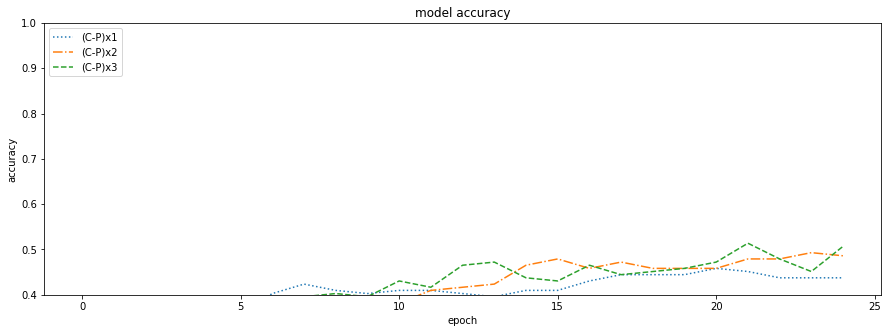

In [8]:
# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1","(C-P)x2","(C-P)x3"]
epochs = 25
for j in range(nets):
    history[j] = model[j].fit(
		x=X_train_females,
		y=y_train_females,
		validation_data= (X_test_females, y_test_females),
		callbacks=[annealer],
    	epochs=epochs,
    	batch_size=128,
		verbose=0
    )
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
plt_data()

# Feature Maps

In [9]:
nets = 5
model = [0] *nets
input_shape=(128, 128, 1)

for j in range(nets):
    model[j] = Sequential()
    model[j].add(Conv2D(j*16+16,kernel_size=5,padding='same',activation='relu',
            input_shape=(128,128,1)))
    model[j].add(MaxPooling2D())
    model[j].add(Conv2D(j*32+32,kernel_size=5,padding='same',activation='relu'))
    model[j].add(MaxPooling2D())
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(8, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

CNN 16 maps: Epochs=25, Train accuracy=0.63542, Validation accuracy=0.45139
CNN 32 maps: Epochs=25, Train accuracy=0.69444, Validation accuracy=0.48611
CNN 64 maps: Epochs=25, Train accuracy=0.78819, Validation accuracy=0.53472
CNN 128 maps: Epochs=25, Train accuracy=0.79340, Validation accuracy=0.54861
CNN 256 maps: Epochs=25, Train accuracy=0.77257, Validation accuracy=0.51389


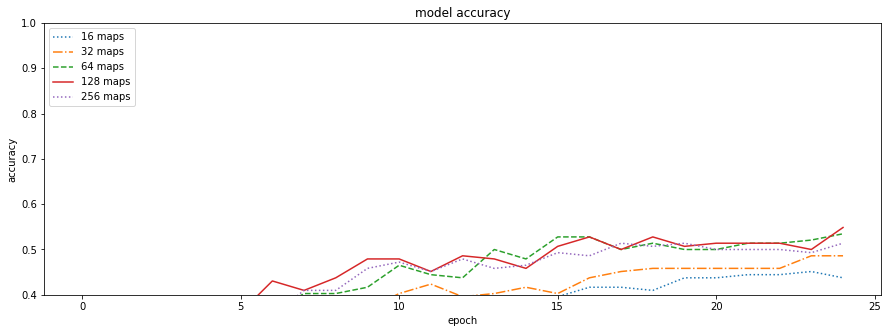

In [10]:
# TRAIN NETWORKS
history = [0] * nets
names = ["16 maps", "32 maps", "64 maps", "128 maps", "256 maps"]
epochs = 25
for j in range(nets):
    history[j] = model[j].fit(
		x=X_train_females,
		y=y_train_females,
		validation_data= (X_test_females, y_test_females),
		callbacks=[annealer],
		epochs=epochs,
		batch_size=128,
		verbose=0
	)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
plt_data()

# Dense Layer Size

In [7]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 7
model = [0] *nets

for j in range(7):
    model[j] = Sequential()
    model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(128,128,1)))
    model[j].add(MaxPooling2D())
    model[j].add(Conv2D(128,kernel_size=5,activation='relu'))
    model[j].add(MaxPooling2D())
    model[j].add(Flatten())
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))
    model[j].add(Dense(8, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

CNN 0N: Epochs=100, Train accuracy=0.84549, Validation accuracy=0.53472
CNN 32N: Epochs=100, Train accuracy=0.94444, Validation accuracy=0.52778
CNN 64N: Epochs=100, Train accuracy=0.89236, Validation accuracy=0.51389
CNN 128N: Epochs=100, Train accuracy=0.89931, Validation accuracy=0.53472
CNN 256N: Epochs=100, Train accuracy=0.85590, Validation accuracy=0.45833
CNN 512N: Epochs=100, Train accuracy=0.91840, Validation accuracy=0.56944
CNN 1024N: Epochs=100, Train accuracy=0.82986, Validation accuracy=0.48611


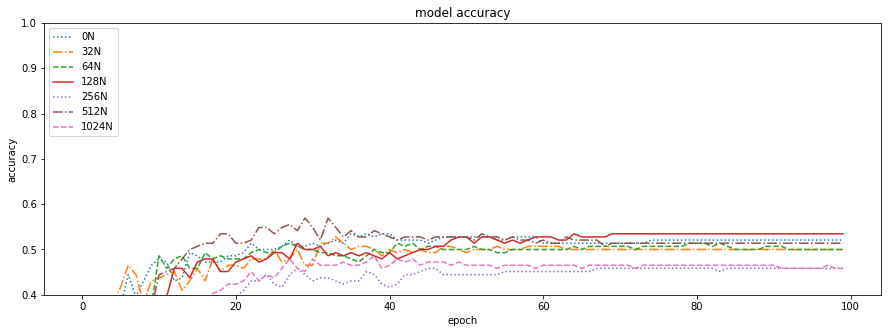

In [8]:
# TRAIN NETWORKS
history = [0] * nets
names = ["0N","32N","64N","128N","256N","512N","1024N"]
epochs = 100
for j in range(nets):
    history[j] = model[j].fit(
		x=X_train_females,
		y=y_train_females,
		validation_data= (X_test_females, y_test_females),
		callbacks=[annealer],
    	epochs=epochs,
    	batch_size=128,
		verbose=0
    )
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
plt_data()

# Dropout

In [15]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(128,128,1)))
    model[j].add(MaxPooling2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(128,kernel_size=5,activation='relu'))
    model[j].add(MaxPooling2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(8, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

CNN D=0: Epochs=100, Train accuracy=0.84201, Validation accuracy=0.52778
CNN D=0.1: Epochs=100, Train accuracy=0.86111, Validation accuracy=0.50694
CNN D=0.2: Epochs=100, Train accuracy=0.85764, Validation accuracy=0.49306
CNN D=0.3: Epochs=100, Train accuracy=0.70139, Validation accuracy=0.49306
CNN D=0.4: Epochs=100, Train accuracy=0.72917, Validation accuracy=0.50000
CNN D=0.5: Epochs=100, Train accuracy=0.65799, Validation accuracy=0.46528
CNN D=0.6: Epochs=100, Train accuracy=0.57639, Validation accuracy=0.44444
CNN D=0.7: Epochs=100, Train accuracy=0.42014, Validation accuracy=0.36806


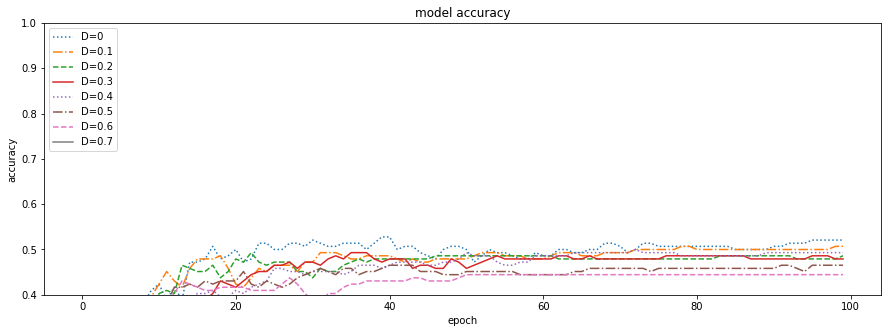

In [16]:
# TRAIN NETWORKS
history = [0] * nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 100
for j in range(nets):
    history[j] = model[j].fit(
		x=X_train_females,
		y=y_train_females,
		validation_data= (X_test_females, y_test_females),
		callbacks=[annealer],
    	epochs=epochs,
    	batch_size=128,
		verbose=0
    )
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
plt_data()